If you haven't yet, start by setting up your environment and datasets by following the instructions in the README. It should be something like:
* `make create_environment`
* `conda activate covid_nlp`
* `make update_environment`
* `make data`

Several common packages that you may want to use (e.g. UMAP, HDBSCAN, enstop, sklearn) have already been added to the `covid_nlp` environment via `environment.yml`. To add more, edit that file and do a:
  ` make update_environment`

## Document embedding of abstracts


In [1]:
# Quick cell to make jupyter notebook use the full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Automatically pick up code changes in the `src` module
%load_ext autoreload
%autoreload 2

In [3]:
import json
import pandas as pd

In [4]:
# Useful imports from easydata
from src import paths
from src.data import Dataset
from src import workflow

In [5]:
# other packages
from scipy import sparse

# tokenizing/vectorizing
from textmap.vectorizers import DocVectorizer
from textmap.tokenizers import SpaCyTokenizer, SKLearnTokenizer
from textmap.tranformers import InformationWeightTransformer, RemoveEffectsTransformer
from vectorizers import NgramVectorizer
from src.data.em_method import em_sparse
import en_core_sci_sm # A full spaCy pipeline for biomedical data.
from scispacy.custom_tokenizer import combined_rule_tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
# dimension reduction
import umap
import umap.plot
# clustering
import hdbscan

/Users/amywooding/miniconda3/envs/covid_nlp/lib/python3.7/site-packages/textmap/tokenizers.py:14: UserWarning: The stanza library could not be imported StanzaTokenizer will not be available.
  warn("The stanza library could not be imported StanzaTokenizer will not be available.")


In [6]:
# Some plotting libraries
import matplotlib.pyplot as plt
%matplotlib inline
from bokeh.plotting import show, save, output_notebook, output_file
from bokeh.resources import INLINE
output_notebook(resources=INLINE)

Loading BokehJS ...

## Load up the dataset

The metadata has been augmented with where the files can be found relative to `paths["interim_data_path"]`

In [7]:
#paths['interim_data_path']

In [8]:
workflow.available_datasets()

['covid_nlp_20200319']

If the previous cell returned an empty list, go back and re-run `make data` as described at the top of this notebook.

In [9]:
ds_name = 'covid_nlp_20200319'

In [10]:
# Load the dataset
meta_ds = Dataset.load(ds_name)

In [11]:
print(meta_ds.DESCR[:457])

COVID-19 Open Research Dataset (CORD-19)
Participate in the CORD-19 Challenge

Kaggle is hosting the COVID-19 Open Research Dataset Challenge, a
series of important questions designed to inspire the community
to use CORD-19 to find new insights about the COVID-19 pandemic
including the natural history, transmission, and diagnostics for
the virus, management measures at the human-animal interface,
lessons from previous epidemiological studies, and more.



In [12]:
# The processed dataframe is the `data` method of this data source 
meta_df = meta_ds.data
meta_df.head()

sha source_x  \
0  c630ebcdf30652f0422c3ec12a00b50241dc9bd9      CZI   
1  53eccda7977a31e3d0f565c884da036b1e85438e      CZI   
2  53eccda7977a31e3d0f565c884da036b1e85438e      PMC   
3  210a892deb1c61577f6fba58505fd65356ce6636      CZI   
4  e3b40cc8e0e137c416b4a2273a4dca94ae8178cc      CZI   

                                               title  \
0  Angiotensin-converting enzyme 2 (ACE2) as a SA...   
1  Comparative genetic analysis of the novel coro...   
2  Comparative genetic analysis of the novel coro...   
3  Incubation Period and Other Epidemiological Ch...   
4  Characteristics of and Public Health Responses...   

                                           doi       pmcid pubmed_id  \
0                   10.1007/s00134-020-05985-9         NaN  32125455   
1                    10.1038/s41421-020-0147-1         NaN       NaN   
2  http://dx.doi.org/10.1038/s41421-020-0147-1  PMC7040011  32133153   
3                           10.3390/jcm9020538         NaN       NaN   
4                           10.3390/jcm9020575         NaN  32093211   

    license                                           abstract publish_time  \
0  cc-by-nc                                                NaN         2020   
1     cc-by                                                NaN         2020   
2     CC BY                                                NaN  2020 Feb 24   
3     cc-by  The geographic spread of 2019 novel coronaviru...         2020   
4     cc-by  In December 2019, cases of unidentified pneumo...         2020   

                                             authors  \
0  Zhang, Haibo; Penninger, Josef M.; Li, Yimin; ...   
1  Cao, Yanan; Li, Lin; Feng, Zhimin; Wan, Shengq...   
2  ['Cao, Yanan', 'Li, Lin', 'Feng, Zhimin', 'Wan...   
3  Linton, M. Natalie; Kobayashi, Tetsuro; Yang, ...   
4                   Deng, Sheng-Qun; Peng, Hong-Juan   

                        journal Microsoft Academic Paper ID WHO #Covidence  \
0            Intensive Care Med                  2002765492          #3252   
1                Cell Discovery                  3003430844          #1861   
2                   Cell Discov                         NaN            NaN   
3  Journal of Clinical Medicine                  3006065484          #1043   
4                    J Clin Med                   177663115          #1999   

  has_full_text           file_type  \
0          True  noncomm_use_subset   
1          True     comm_use_subset   
2          True     comm_use_subset   
3          True     comm_use_subset   
4          True     comm_use_subset   

                                                path  
0  noncomm_use_subset/c630ebcdf30652f0422c3ec12a0...  
1  comm_use_subset/53eccda7977a31e3d0f565c884da03...  
2  comm_use_subset/53eccda7977a31e3d0f565c884da03...  
3  comm_use_subset/210a892deb1c61577f6fba58505fd6...  
4  comm_use_subset/e3b40cc8e0e137c416b4a2273a4dca...

In [13]:
# optionally filter it down to published papers with a cc-by license

meta_df.file_type.value_counts()

comm_use_subset       9011
noncomm_use_subset    1976
pmc_custom_license    1429
biorxiv_medrxiv        803
Name: file_type, dtype: int64

In [14]:
meta_df = meta_df[(meta_df.file_type=='comm_use_subset') | (meta_df.file_type=='noncomm_use_subset')].copy()

## Basics on the dataset

The JSON files given in the `path` column of the metadata dataframe are the papers in `json` format (as dicts)
that include the following keys:
* `paper_id`
* `metadata`
* `abstract`
* `body_text`
* `bib_entries`
* `ref_entries`
* `back_matter`

where the `paper_id` is the sha hash from the medadata.

For example:

In [15]:
filename = paths['interim_data_path'] / ds_name / meta_df['path'][0]
file = json.load(open(filename, 'rb'))
file.keys()

dict_keys(['paper_id', 'metadata', 'abstract', 'body_text', 'bib_entries', 'ref_entries', 'back_matter'])

# Embedding abstracts

In [16]:
abstracts = meta_df.abstract.dropna()

In [17]:
abstracts[:5]

3     The geographic spread of 2019 novel coronaviru...
4     In December 2019, cases of unidentified pneumo...
6     The basic reproduction number of an infectious...
7     The initial cluster of severe pneumonia cases ...
10    Cruise ships carry a large number of people in...
Name: abstract, dtype: object

In [18]:
len(abstracts)

10606

Shorten abstracts for display

In [19]:
short_abstracts = [a[:140] for a in abstracts]

In [20]:
meta_df['abstract_length'] = meta_df.abstract.str.len()

In [21]:
hover_df = meta_df[meta_df.abstract_length > 0].reset_index()
hover_df['short_abstracts'] = short_abstracts

In [60]:
def umap_explore(matrix, hover_df, random_state=42, min_cluster_size=10):
    """
    Function to make comparing embeddings via UMAP+HDBSCAN easier (and this notebook cleaner)
    
    UMAP + HDBSCAN
    """
    embedding_2d = umap.UMAP(n_components=2, n_neighbors=10,
                             metric='hellinger',
                             random_state=random_state).fit(matrix)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size)
    clusterer.fit_predict(embedding_2d.embedding_)
    hover_df['cluster'] = clusterer.labels_
    
    value_counts = hover_df.cluster.value_counts()
    print(f"Number of clusters: {len(value_counts)}")
    print(f"Cluster value counts:\n{value_counts}")

    return embedding_2d, hover_df['cluster'] 


## Vectorize to get word-document matrix using defaults

NLTK tokenizer

In [23]:
%%time
vectorizer = DocVectorizer()
word_doc_matrix = vectorizer.fit_transform(abstracts)

CPU times: user 1min 21s, sys: 1.62 s, total: 1min 23s
Wall time: 1min 27s


In [24]:
%%time
embedding_2d, labels = umap_explore(word_doc_matrix, hover_df)

Number of clusters: 11
Cluster value counts:
 8    9174
-1     590
 3     422
 6     149
 9      69
 5      55
 0      44
 2      35
 4      32
 1      20
 7      16
Name: cluster, dtype: int64
CPU times: user 1min 21s, sys: 1.4 s, total: 1min 22s
Wall time: 1min 22s


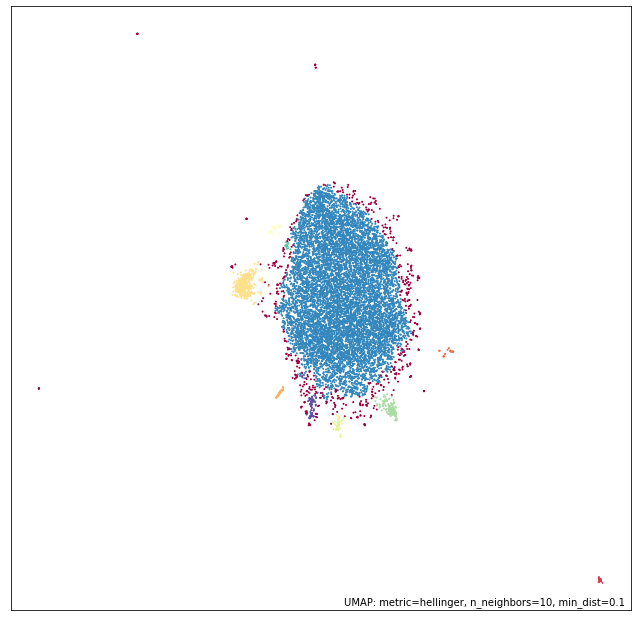

In [25]:
umap.plot.points(embedding_2d, labels=labels, show_legend=False);

## Vectorize the abstracts using scispacy

#### Set up tokenizer

We'll use scispacy

In [26]:
nlp = en_core_sci_sm.load()
nlp.tokenizer = combined_rule_tokenizer(nlp)

In [27]:
spacy_tokenizer = SpaCyTokenizer(nlp=nlp)
# We just want the tokenization !
spacy_tokenizer.nlp.remove_pipe('tagger')
spacy_tokenizer.nlp.remove_pipe('parser')
spacy_tokenizer.nlp.remove_pipe('ner')

('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x1a40231590>)

#### Vectorize to get word-document matrix

In [28]:
%%time
vectorizer = DocVectorizer(tokenizer=spacy_tokenizer)
word_doc_matrix = vectorizer.fit_transform(abstracts)

CPU times: user 1min, sys: 1.13 s, total: 1min 1s
Wall time: 1min 1s


Number of clusters: 5
Cluster value counts:
 3    10155
 1      297
 2      124
 0       18
-1       12
Name: cluster, dtype: int64
CPU times: user 1min 3s, sys: 1.38 s, total: 1min 5s
Wall time: 1min 5s


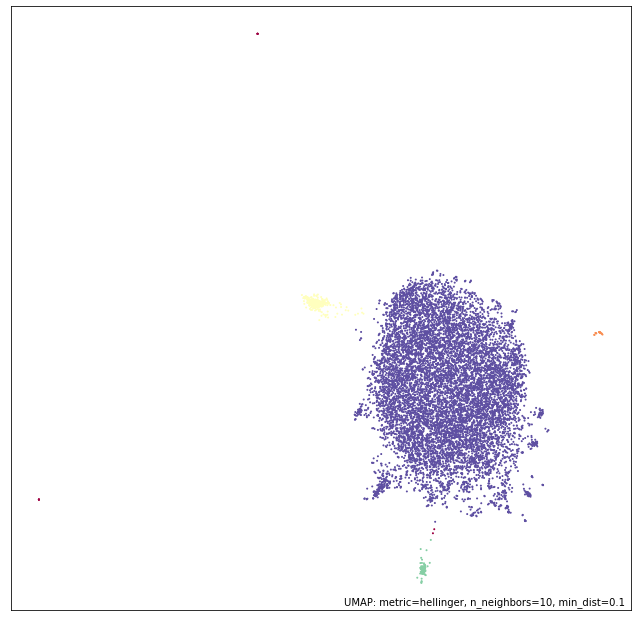

In [29]:
%%time
embedding_2d, labels = umap_explore(word_doc_matrix, hover_df)
umap.plot.points(embedding_2d, labels=labels, show_legend=False);

# Broken Down Steps of Defaults + scispacy

## Step 1: Tokenize

In [30]:
%%time
spacy_tokenizer.fit(abstracts)

CPU times: user 52.9 s, sys: 782 ms, total: 53.7 s
Wall time: 53.9 s


SpaCyTokenizer(collocation_score_function=<bound method NgramAssocMeasures.likelihood_ratio of <class 'nltk.metrics.association.BigramAssocMeasures'>>,
               max_collocation_iterations=2, min_collocation_score=12,
               nlp=<spacy.lang.en.English object at 0x1a35c0f1d0>)

In [31]:
%%time
tokens_by_doc = spacy_tokenizer.tokens_by_doc()

CPU times: user 211 ms, sys: 4.46 ms, total: 215 ms
Wall time: 457 ms


In [32]:
tokens_by_doc[0][:10]

('The',
 'geographic_spread',
 'of',
 '2019_novel_coronavirus_(',
 'COVID-19_)',
 'infections',
 'from_the',
 'epicenter_of_Wuhan_,',
 'China_,',
 'has_provided_an_opportunity')

## Step 2: Inital vectorization

In [33]:
ngram_vectorizer = NgramVectorizer(ngram_size=1)

In [34]:
%%time
representation = ngram_vectorizer.fit_transform(tokens_by_doc)

CPU times: user 10.2 s, sys: 433 ms, total: 10.7 s
Wall time: 11 s


Number of clusters: 5
Cluster value counts:
 3    10190
 1      268
 2       91
-1       42
 0       15
Name: cluster, dtype: int64
CPU times: user 1min 33s, sys: 3.89 s, total: 1min 37s
Wall time: 1min 38s


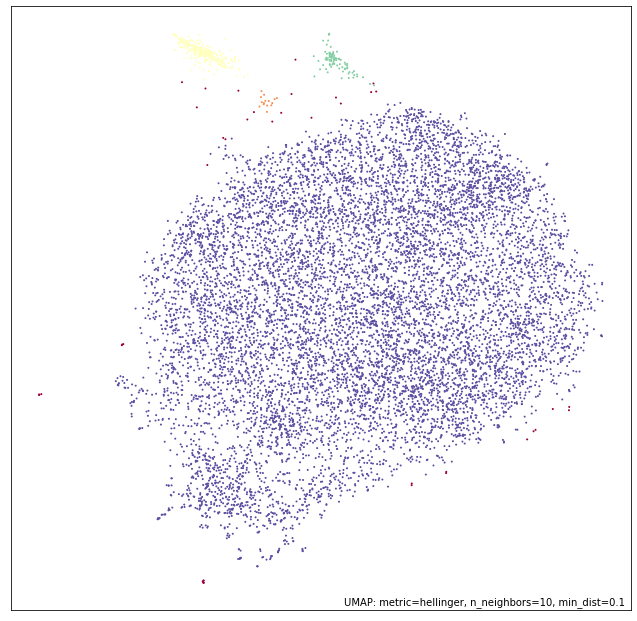

In [35]:
%%time
embedding_2d, labels = umap_explore(representation, hover_df)
umap.plot.points(embedding_2d, labels=labels, show_legend=False);

## Step 3: Information Weight Transform

In [36]:
iwt = InformationWeightTransformer()

In [37]:
%%time
iwt_representation = iwt.fit_transform(representation)

CPU times: user 631 ms, sys: 57.4 ms, total: 688 ms
Wall time: 419 ms


Number of clusters: 4
Cluster value counts:
 0    10176
 1      277
 2      128
-1       25
Name: cluster, dtype: int64
CPU times: user 1min 23s, sys: 3.51 s, total: 1min 27s
Wall time: 1min 28s


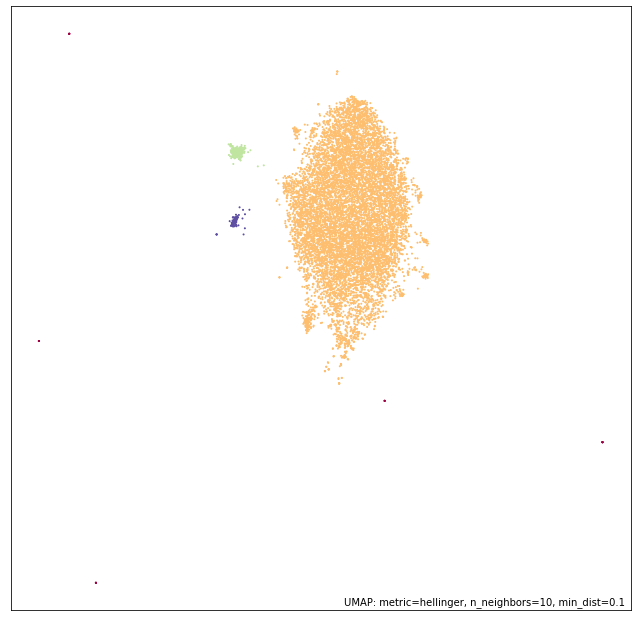

In [38]:
%%time
embedding_2d, labels = umap_explore(iwt_representation, hover_df)
umap.plot.points(embedding_2d, labels=labels, show_legend=False);

## Step 4: Remove Effects Transformer

In [39]:
ret = RemoveEffectsTransformer()

In [40]:
%%time
ret_representation = ret.fit_transform(iwt_representation)

CPU times: user 567 ms, sys: 58.1 ms, total: 625 ms
Wall time: 396 ms


Number of clusters: 5
Cluster value counts:
 2    10159
 3      285
 0      126
-1       18
 1       18
Name: cluster, dtype: int64
CPU times: user 1min 22s, sys: 3.44 s, total: 1min 26s
Wall time: 1min 27s


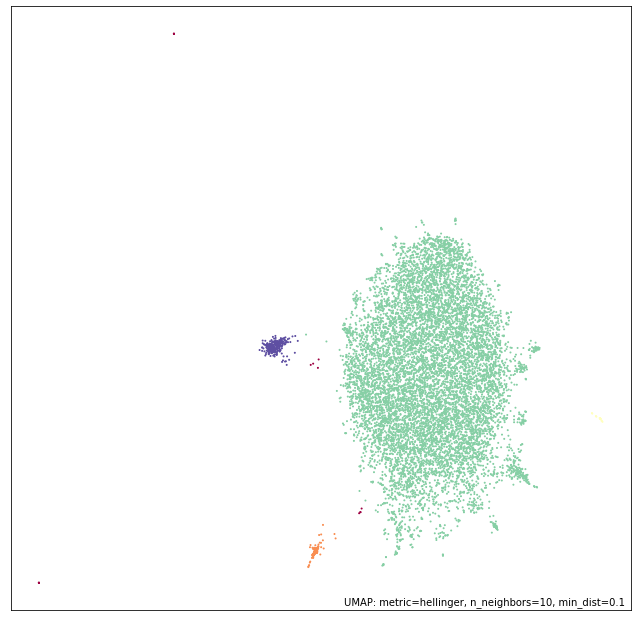

In [41]:
%%time
embedding_2d, labels = umap_explore(ret_representation, hover_df)
umap.plot.points(embedding_2d, labels=labels, show_legend=False);

## Now using SKLearnTokenizer (countvectorizer alone)

In [42]:
%%time
vectorizer = DocVectorizer(tokenizer=SKLearnTokenizer(),
                           info_weight_transformer=None,
                           remove_effects_transformer=None)
word_doc_matrix = vectorizer.fit_transform(abstracts)

CPU times: user 59.2 s, sys: 1.38 s, total: 1min
Wall time: 1min 6s


Number of clusters: 10
Cluster value counts:
 8    8968
-1     800
 2     247
 3     216
 0     200
 7      71
 6      39
 1      24
 5      22
 4      19
Name: cluster, dtype: int64
CPU times: user 55.6 s, sys: 654 ms, total: 56.2 s
Wall time: 56.1 s


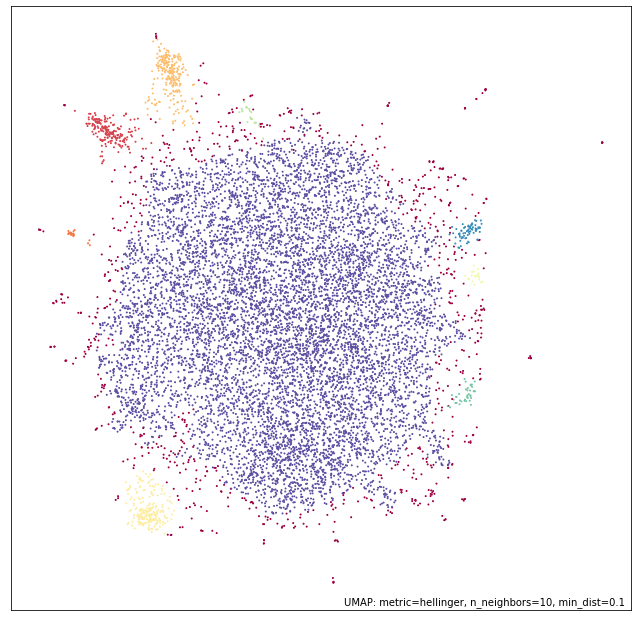

In [43]:
%%time
embedding_2d, labels = umap_explore(word_doc_matrix, hover_df)
umap.plot.points(embedding_2d, labels=labels, show_legend=False);

## Now using SKLearnTokenizer + transformers

In [44]:
%%time
vectorizer = DocVectorizer(tokenizer=SKLearnTokenizer())
word_doc_matrix = vectorizer.fit_transform(abstracts)

CPU times: user 49.9 s, sys: 789 ms, total: 50.7 s
Wall time: 50.7 s


Number of clusters: 15
Cluster value counts:
 13    8214
-1     1167
 4      277
 5      238
 1      172
 9      159
 8       82
 11      57
 0       50
 3       45
 10      45
 7       30
 12      27
 6       25
 2       18
Name: cluster, dtype: int64
CPU times: user 47.8 s, sys: 612 ms, total: 48.4 s
Wall time: 48.2 s


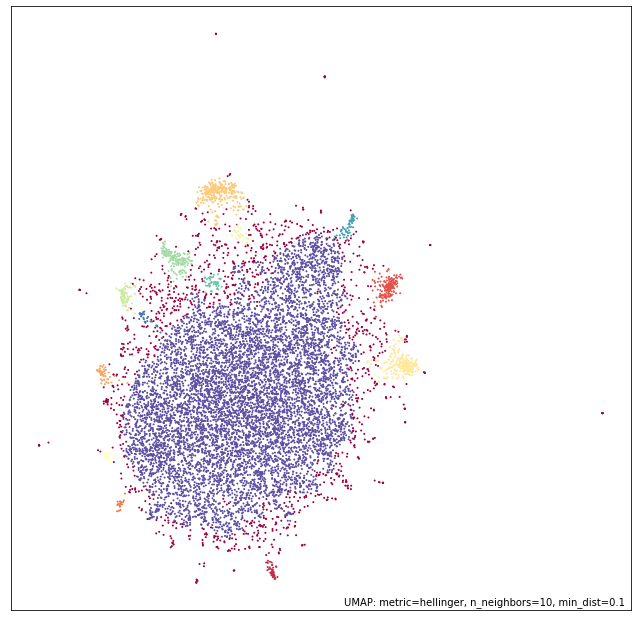

In [45]:
%%time
embedding_2d, labels = umap_explore(word_doc_matrix, hover_df)
umap.plot.points(embedding_2d, labels=labels, show_legend=False);

## Naive DocMAP (countvectorizer)

In [58]:
%%time
vectorizer = CountVectorizer(min_df=5, tokenizer=spacy_tokenizer)
word_doc_matrix = vectorizer.fit_transform(abstracts)

CPU times: user 15.4 s, sys: 157 ms, total: 15.6 s
Wall time: 16.2 s


Number of clusters: 117
Cluster value counts:
-1      4522
 87      581
 61      406
 16      347
 30      233
        ... 
 109      11
 52       11
 38       10
 22       10
 111      10
Name: cluster, Length: 117, dtype: int64
CPU times: user 1min 6s, sys: 974 ms, total: 1min 7s
Wall time: 1min 10s


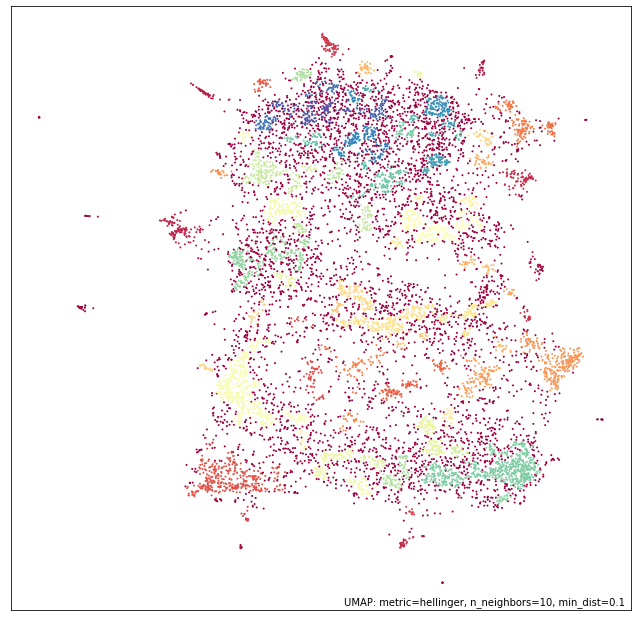

In [61]:
%%time
embedding_2d, labels = umap_explore(word_doc_matrix, hover_df, min_cluster_size=10)
umap.plot.points(embedding_2d, labels=labels, show_legend=False);

## Naive DocMAP (tfidf)

In [50]:
%%time
vectorizer = TfidfVectorizer(min_df=5, tokenizer=spacy_tokenizer)
word_doc_matrix = vectorizer.fit_transform(abstracts)

CPU times: user 14.9 s, sys: 124 ms, total: 15 s
Wall time: 15.1 s


Number of clusters: 106
Cluster value counts:
-1     4671
 53     347
 32     312
 25     243
 21     214
       ... 
 47      16
 29      16
 71      15
 24      15
 74      15
Name: cluster, Length: 106, dtype: int64
CPU times: user 1min, sys: 1.56 s, total: 1min 2s
Wall time: 1min 2s


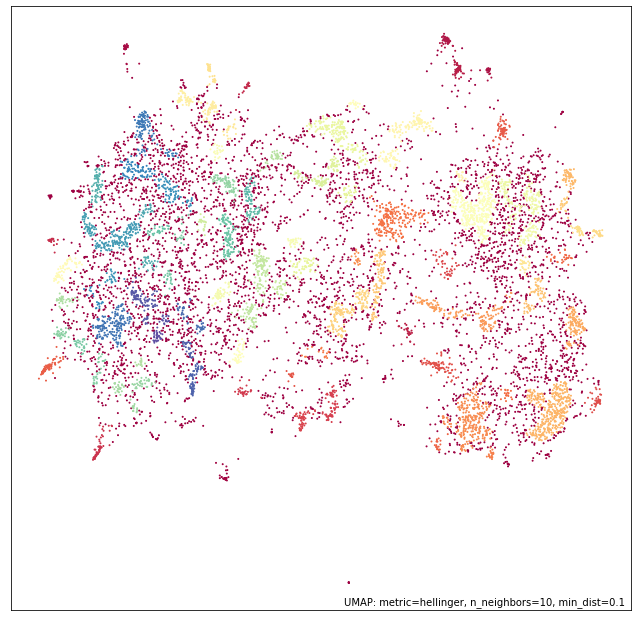

In [51]:
%%time
embedding_2d, labels = umap_explore(word_doc_matrix, hover_df, min_cluster_size=10)
umap.plot.points(embedding_2d, labels=labels, show_legend=False);

## Naive DocMAP improved (tfidf)
L1 normalize, EM

### Step 1: Tfidf

In [52]:
%%time
vectorizer = TfidfVectorizer(min_df=5, norm='l1', tokenizer=spacy_tokenizer)
word_doc_matrix = vectorizer.fit_transform(abstracts)

CPU times: user 24.3 s, sys: 542 ms, total: 24.9 s
Wall time: 25.4 s


Number of clusters: 104
Cluster value counts:
-1      4652
 53      323
 37      298
 32      282
 95      224
        ... 
 22       16
 66       16
 16       16
 101      16
 80       15
Name: cluster, Length: 104, dtype: int64
CPU times: user 1min 4s, sys: 1.96 s, total: 1min 6s
Wall time: 1min 7s


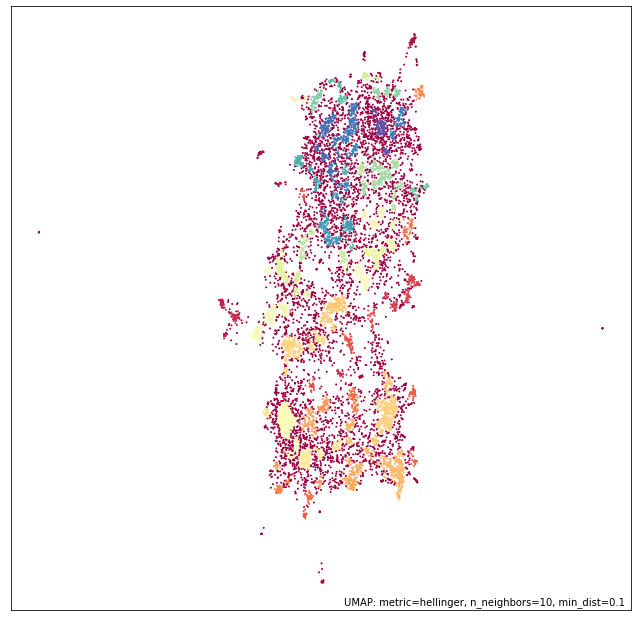

In [53]:
%%time
embedding_2d, labels = umap_explore(word_doc_matrix, hover_df, min_cluster_size=10)
umap.plot.points(embedding_2d, labels=labels, show_legend=False);

### Step 2: EM

In [54]:
word_doc_matrix, weights = em_sparse(word_doc_matrix, prior_noise=5.0)

Number of clusters: 121
Cluster value counts:
-1      4312
 59      235
 91      200
 49      165
 61      138
        ... 
 52       16
 58       16
 100      16
 92       15
 64       15
Name: cluster, Length: 121, dtype: int64
CPU times: user 41.4 s, sys: 1.5 s, total: 42.9 s
Wall time: 43.3 s


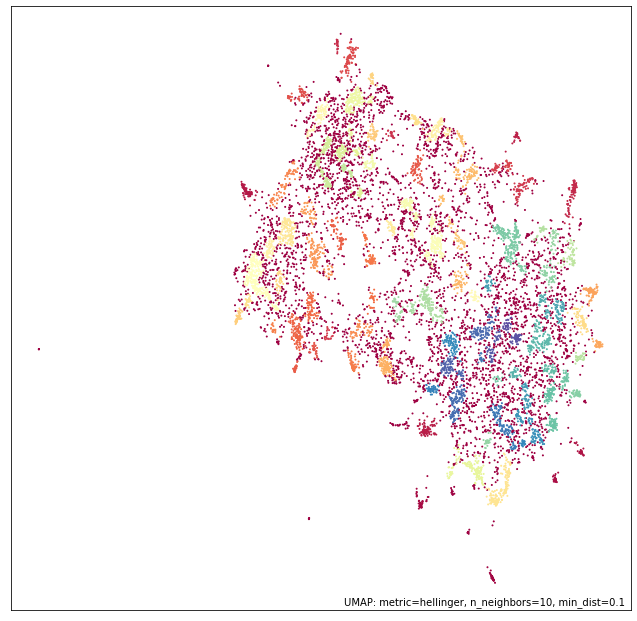

In [55]:
%%time
embedding_2d, labels = umap_explore(word_doc_matrix, hover_df, min_cluster_size=10)
umap.plot.points(embedding_2d, labels=labels, show_legend=False);